### Import Libraries

In [1]:
from wrapper_functions_CAR import *
tf.config.run_functions_eagerly(True)
np.random.seed(10)

C:\Users\nickl\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\nickl\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


TensorFlow version: 2.10.0. Expected: 2.7.0
TensorFlow Probability version: 0.18.0. Expected: 0.15.0


### Create the fake data



In [2]:
#training2010 = pd.read_csv('../data/merged_wp_census_data_280922.csv')
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
models = ['acs', 'pep', 'worldpop']

In [3]:
def simulate_data_one_model(data, adjacency):
    data['acs'] = np.random.normal(80.0, 10.0, data.shape[0])
    data['pep'] = np.random.normal(100.0, 10.0, data.shape[0])
    data['worldpop'] = np.random.normal(120.0, 10.0, data.shape[0])
    
    tau2 = 1
    rho = 0.3
    print('fixing tau2 and rho')

    data = data
    nchain = 1

    data['census'] = np.random.poisson(data['worldpop'].to_numpy())
    
    return data

In [4]:
def simulate_data(data, adjacency, pivot = -1, sim_numbers = False, one_model = False):
    """Simulated data for the CAR model. 
    
    Args:
        data: The input data file.
        adjacency: the adjacency matrix for the data.
        pivot: The column to be used as the pivot for the softmax ensemble weights. -1 indicates no pivot.
        sim_numbers: whether to simulate data values for the models. If false, the true values are used.
        one_model: whether to only have one model determine the output. Worldpop is the default if this is chosen.
    """
    if sim_numbers:
        data['acs'] = np.random.normal(80.0, 10.0, data.shape[0])
        data['pep'] = np.random.normal(100.0, 10.0, data.shape[0])
        data['worldpop'] = np.random.normal(120.0, 10.0, data.shape[0])
    
    if one_model:
        data['census'] = np.random.poisson(data['worldpop'].to_numpy())
        
        return _, _, data
    else:
        tau2 = 1
        rho = 0.3
        print('fixing tau2 and rho')

        data = data
        nchain = 1

        Q = (1/tau2)*(np.diag(adjacency.sum(axis=1)) - rho*adjacency)
        Q = tf.constant(Q, dtype = tf.float32)

        if(pivot == -1):
            phi_true = tf.constant(np.array([mv_normal_sample(precision_matrix = Q, 
                                                          num_models = 3) for i in range(nchain)]),
                               dtype = tf.float32)

        elif(pivot in range(3)):
            phi_np = np.array([mv_normal_sample(precision_matrix = Q,
                                          num_models = 2) for i in range(nchain)])
            phi_np = np.insert(phi_np, pivot, 0., axis = 2)
            phi_true = tf.constant(phi_np, dtype = tf.float32)

        else:
            raise Exception('Pivot needs to be -1, 0, 1, or 2')

        # get exponentiated values and sum across models
        exp_phi = tf.math.exp(phi_true)
        exp_phi_rows = tf.reduce_sum(exp_phi, 2)

        # get model weights and calculate mean estimate
        u_true = exp_phi/exp_phi_rows[...,None]

        tmp = data[models].values*u_true
        n = tf.reduce_sum(tmp, axis = 2)

        data['census'] = np.random.poisson(n)[0]

    return phi_true, u_true, data


In [5]:
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')
#phi_true, u_true, data = simulate_data(data_NY, adj_NY, sim_numbers = True, pivot = -1, one_model = True)
#data = simulate_data2(data_NY, adj_NY)
data_sub = data_NY
adj_sub = adj_NY

In [6]:
# data_TX, adj_TX = subset_data_by_state(training2010, county_adj, ', Texas', 'TX')
# Had to put in the comma because there are some cities in other states with "Texas" in the name
# phi_true, u_true, data = simulate_data(data_TX, adj_TX)

# Default Configs

In [7]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

#### Running with HMC

In [12]:
mcmc_config = DEFAULT_MCMC_CONFIG.copy()
mcmc_config.update(dict(burnin = 2_500, num_steps = 10_000, nchain = 5, 
                        kernel_type = 'hmc', step_adaptor_type = 'simple'))
mcmc_config

{'step_size': 0.1,
 'num_steps': 10000,
 'burnin': 2500,
 'nchain': 5,
 'seed': 0,
 'kernel_type': 'hmc',
 'step_adaptor_type': 'simple'}

In [ ]:
res_dict = {}
for pivot_DGP in range(-1, 3):
    print('pivot DGP: ' + str(pivot_DGP))
    
    phi_true, u_true, data_pivot = simulate_data(data_NY, adj_NY, sim_numbers = False, pivot = pivot_DGP, one_model = False)
    
    for pivot_fit in range(-1, 3):
        print('pivot fit: ' + str(pivot_fit))
        t0 = time.perf_counter()
        CAR_samples, chain_samples, sampler_stat = run_mcmc_CAR(data = data_pivot,
                                                                adjacency = adj_NY,
                                                                pivot = pivot_fit,
                                                                models = models,                                                        
                                                                debug_mode = True,
                                                                **mcmc_config)  
        print(time.perf_counter() - t0)
        
        res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)] = [CAR_samples, chain_samples, sampler_stat, phi_true, u_true, data_pivot, pivot_DGP, pivot_fit]
        

pivot DGP: -1
fixing tau2 and rho
pivot fit: -1
fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
True
0
-1211376640.0...1000
-1211376768.0...2000
-1211376768.0...3000
-1211376768.0...4000


C:\Users\nickl\AppData\Local\Temp\ipykernel_7688\2020791847.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['census'] = np.random.poisson(n)[0]


-1211376768.0...5000
-1211376896.0...6000
-1211376768.0...7000
-1211376896.0...8000
-1211376768.0...9000
-1211376768.0...10000
-1211376896.0...11000
-1211376896.0...12000
-1211376896.0...13000
-1211376896.0...14000
-1211376896.0...15000
-1211376896.0...16000
-1211376768.0...17000
-1211376768.0...18000
-1211376896.0...19000
-1211376768.0...Done.
kernel type is hmc
simple step size
10000
<function run_chain_CAR.<locals>.trace_fn at 0x00000170E2E87790>


Saving and loading Python objects with Pickle

In [60]:
import pickle

# using local data file because these are too big for github
local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
#local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
with open(local_dir + 'CAR_samples_DEBUG_NY_n10000_realdata_multiple_pivot_Apr182023.pickle', 'wb') as results_file:
  pickle.dump([res_dict, mcmc_config], results_file)
  #pickle.dump([CAR_samples, CAR_samples0, CAR_samples1, CAR_samples2, CAR_samples], results_file)

### Loading results and analyzing

In [ ]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_DEBUG_NY_n50000_hmc_NY_Mar152023.pickle'
with open(file, "rb") as input_file:
     #CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub = pickle.load(input_file)
    CAR_samples, chain_samples, sampler_stat, mcmc_config, data_sub = pickle.load(input_file)

In [10]:
for key in res_dict.keys():
    print(key)
    chain_samples = res_dict[key][1]
    ESS = tfp.mcmc.effective_sample_size(chain_samples, cross_chain_dims = 1).numpy()
    rhat = tfp.mcmc.potential_scale_reduction(chain_samples, independent_chain_ndims=1).numpy()
    print(ESS.mean())
    print(rhat.mean())

pDGP: -1; pfit: -1
7.1917644
6.20373
pDGP: -1; pfit: 0
4.9999995
69926240000000.0
pDGP: -1; pfit: 1
4.9999995
59169646000000.0
pDGP: -1; pfit: 2
8.843915
4.403316
pDGP: 0; pfit: -1
4.9999995
91163010000000.0
pDGP: 0; pfit: 0
4.9999995
59300244000000.0
pDGP: 0; pfit: 1
4.9999995
81858690000000.0
pDGP: 0; pfit: 2
4.9999995
67387185000000.0
pDGP: 1; pfit: -1
4.9999995
85586170000000.0
pDGP: 1; pfit: 0
6.1626368
13.081305
pDGP: 1; pfit: 1
5.411506
31.435541
pDGP: 1; pfit: 2
4.9999995
inf
pDGP: 2; pfit: -1
4.9999995
59267004000000.0
pDGP: 2; pfit: 0
4.9999995
80572050000000.0
pDGP: 2; pfit: 1
5.199597
102.68561
pDGP: 2; pfit: 2
4.9999995
81864170000000.0


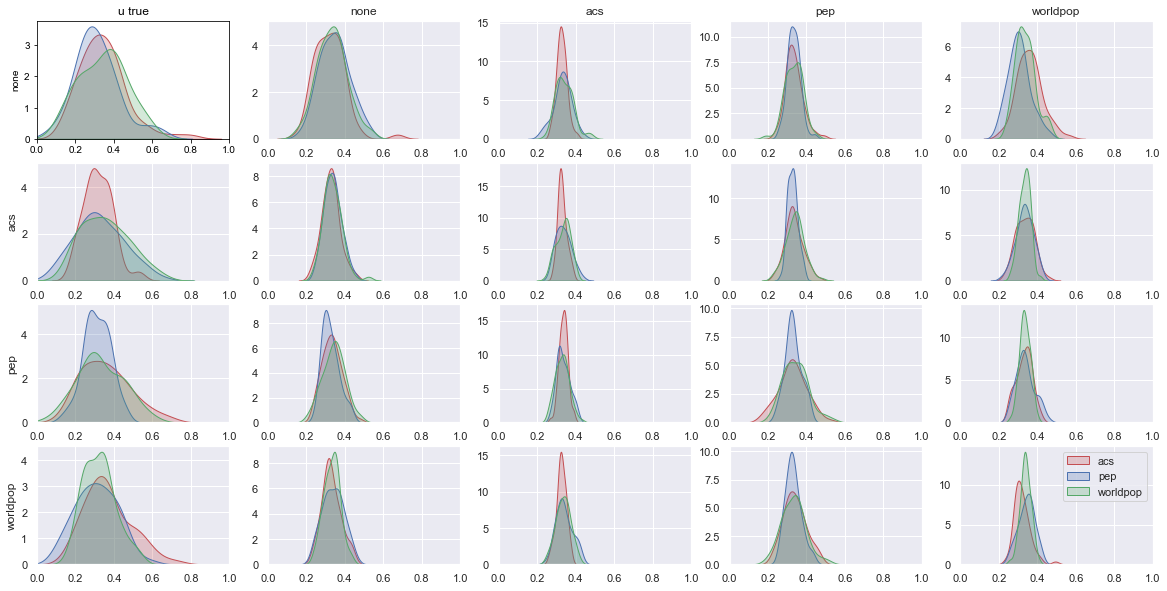

In [11]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [20, 10]
labels = models[:]
labels.insert(0, 'none')

fig = plt.figure()
iter = 0

for pivot_DGP in range(-1,3):
    
    iter = iter + 1
    plt.subplot(4, 5, iter)
    
    u_true = res_dict['pDGP: ' + str(pivot_DGP) + '; pfit: -1'][4]
    
    CAR_df = pd.DataFrame(u_true[0,:,:], columns = ["acs","pep","worldpop"])
    #CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

    plt.subplot(4, 5, iter)
    sns.set(style="darkgrid")
    tt = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
    tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
    tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
    if pivot_DGP == -1:
        plt.title('u true')
    plt.ylabel(labels[pivot_DGP + 1])
    plt.xlabel('')
    plt.xlim(0,1)
    
    for pivot_fit in range(-1,3):
        iter = iter + 1
        key = 'pDGP: ' + str(pivot_DGP) + '; pfit: ' + str(pivot_fit)    
        #print(key)
        CAR_samples = res_dict[key][0]
        CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2).numpy()
        if pivot_fit > -1:
            CAR_ensemble_weights = tf.constant(np.insert(CAR_ensemble_weights, pivot_fit, 0., axis = 1))
        #CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2)

        # get exponentiated values and sum across models
        exp_phi = tf.math.exp(CAR_ensemble_weights)

        exp_phi_rows = tf.reduce_sum(exp_phi, 1)

        # get model weights and calculate mean estimate
        u = exp_phi/exp_phi_rows[...,None]

        CAR_df = pd.DataFrame(u, columns = ["acs","pep","worldpop"])
        #CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

        plt.subplot(4, 5, iter)
        sns.set(style="darkgrid")
        tt = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
        tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
        tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
        #plt.legend()
        plt.xlabel('')
        plt.ylabel('')
        if pivot_DGP == -1:
            plt.title(labels[pivot_fit + 1])
        plt.xlim(0,1)
        
plt.legend()
plt.show()

In [30]:
## Get the average y predictions from the MCMC samples

pivot = 0
predictions = np.empty(shape=(CAR_samples[0].shape[0], CAR_samples[0].shape[2]), dtype='object')
for i in range(CAR_samples[0].shape[2]):
    phi_vals = CAR_samples[0][:,:,i].numpy()
    phi_vals = np.insert(phi_vals, pivot, 0., axis = 1)
    
    # get exponentiated values and sum across models
    exp_phi = tf.math.exp(tf.constant(phi_vals))

    exp_phi_rows = tf.reduce_sum(exp_phi, 1)

    # get model weights and calculate mean estimate
    u = exp_phi/exp_phi_rows[...,None]

    tmp = data_sub[models].values*u
    predictions[:,i] = tf.reduce_sum(tmp, axis = 1)
    
y_pred = np.mean(predictions, axis = 1)

In [17]:
## Get the average ensemble weights from the CAR samples

CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2).numpy()
CAR_ensemble_weights = tf.constant(np.insert(CAR_ensemble_weights, pivot, 0., axis = 1))
#CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2)

# get exponentiated values and sum across models
exp_phi = tf.math.exp(CAR_ensemble_weights)

exp_phi_rows = tf.reduce_sum(exp_phi, 1)
    
# get model weights and calculate mean estimate
u = exp_phi/exp_phi_rows[...,None]

In [ ]:
# Create the weights dict for plotting the outcomes

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [ ]:
from scipy.stats import pearsonr
pearsonr(data_sub['census'],data_sub['pep'])[0], pearsonr(data_sub['census'],data_sub['acs'])[0], pearsonr(data_sub['census'],data_sub['worldpop'])[0]

C:\Users\Admin-Dell\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


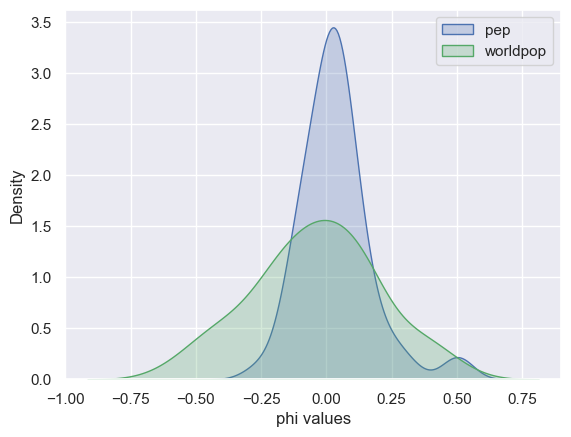

In [44]:
import seaborn as sns

CAR_ensemble_weights = tf.reduce_mean(CAR_samples[0], axis = 2).numpy()
CAR_ensemble_weights = np.insert(CAR_ensemble_weights, pivot, 0., axis = 1)

CAR_df = pd.DataFrame(CAR_ensemble_weights, columns = ["acs","pep","worldpop"])
#CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

sns.set(style="darkgrid")
fig = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
fig = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
fig = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
plt.legend()
plt.xlabel('phi values')
plt.show()

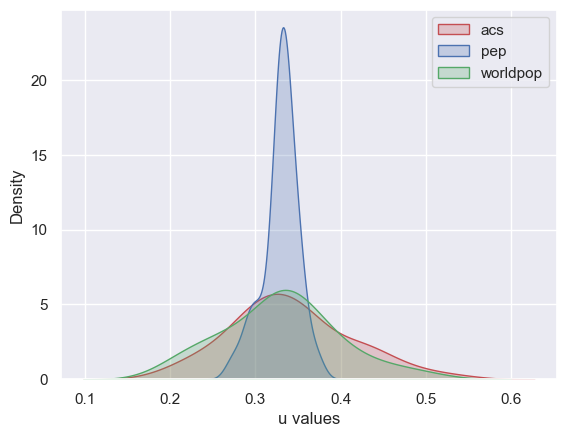

In [18]:
import seaborn as sns

CAR_df = pd.DataFrame(u, columns = ["acs","pep","worldpop"])
#CAR_df = pd.DataFrame(CAR_ensemble_weights.numpy(), columns = ["acs","pep","worldpop"])

sns.set(style="darkgrid")
fig = sns.kdeplot(CAR_df['acs'], shade=True, color="r", label = 'acs')
fig = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
fig = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
plt.legend()
plt.xlabel('u values')
plt.show()

In [ ]:
# get exponentiated values and sum across models
exp_phi = tf.math.exp(CAR_ensemble_weights)
exp_phi_rows = tf.reduce_sum(exp_phi, 1)

# get model weights and calculate mean estimate
u = exp_phi/exp_phi_rows[...,None]

In [ ]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [23]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([data_sub[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
# pd.concat([data_NY[["GEOID"]].reset_index(drop=True), pd.DataFrame( phi_true[0].numpy(), columns = models)], axis=1)
# pd.DataFrame( phi_true[0].numpy(), columns = models)

In [19]:
full_phi = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(phi_true[0].numpy(), columns = models)], 
                        axis=1)

full_u = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(u_true[0].numpy(), columns = models)], 
                        axis=1)


#full_phi[['GEOID', 'acs']], full_u

In [ ]:
for model_name in models:
    output = full_phi[['GEOID', model_name]]
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
phi_true.shape

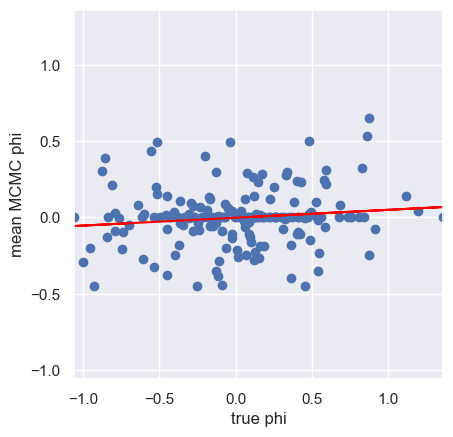

0.12899427461792656

In [22]:
x = np.ndarray.flatten(full_phi.iloc[:,1:].to_numpy())
y = np.ndarray.flatten(CAR_ensemble_weights.numpy())
plt.scatter(x, y)

plt.xlabel("true phi")
plt.ylabel("mean MCMC phi")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]

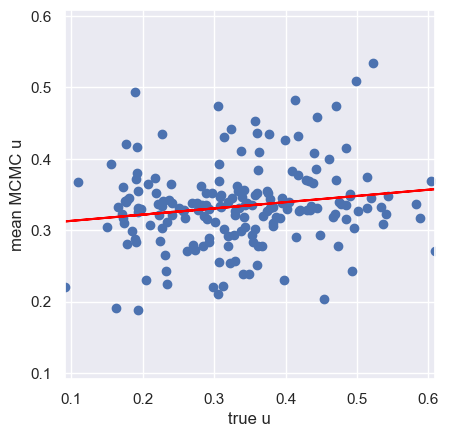

0.16566927052890634

In [24]:
x = np.ndarray.flatten(full_u.iloc[:,1:].values)
y = np.ndarray.flatten(u.numpy())
plt.scatter(x, y)
plt.xlabel("true u")
plt.ylabel("mean MCMC u")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]

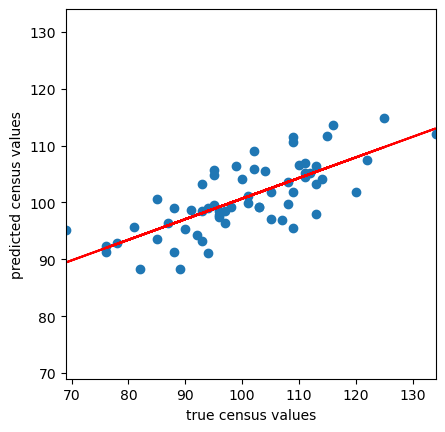

0.7430811131159853

In [40]:
x = data_sub['census']
y = y_pred
#y = y_pred.numpy()
plt.scatter(x, y)
plt.xlabel("true census values")
plt.ylabel("predicted census values")

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y.astype('float64'), 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

#add linear regression line to scatterplot 
plt.plot(x, m*x+b, color = 'red')

plt.show()

from scipy.stats import pearsonr
pearsonr(x,y)[0]